# Deep Learning HW2

Gerald Baulig 0780827 2019/12/02

GitHub: https://github.com/bugerry87/fcnn_scratch

In this assignment we were asked to implement a convolutional neural network from scratch.

1. Implement a regression network, and
2. implement a classification network.

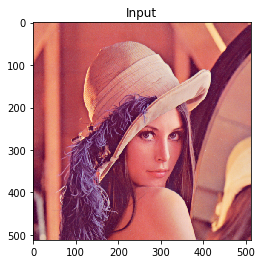

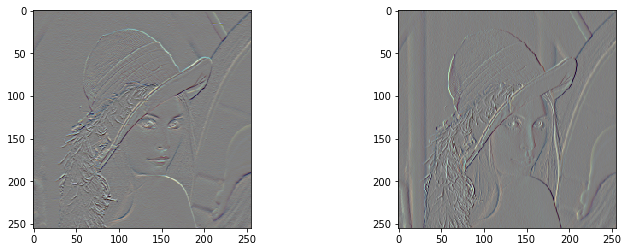

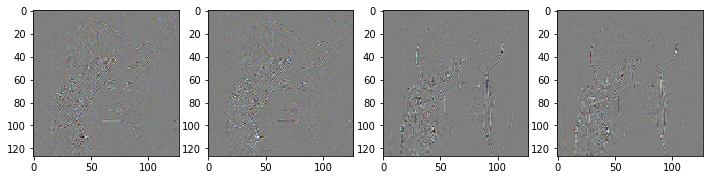

In [173]:
import numpy as np
import matplotlib.pylab as plt
from PIL import Image

def shape_nvuc(arr):
    if arr.ndim == 4:
        pass
    elif arr.ndim == 2:
        arr = arr[None,:,:,None]
    elif arr.ndim == 3:
        arr = arr[None,:,:,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)

def indices(xn, kn, kv, ku):
    indices = np.indices((xn, kn, kv, ku))
    indices = np.reshape(indices, (4, xn * kn * kv * ku))
    indices = np.swapaxes(indices, 0, 1)
    return indices

class Conv2D():
    def __init__(self, strid=(1,1), norm=None, keepdims=True):
        self.stv = strid[0]
        self.stu = strid[1]
        self.norm = norm
        self.keepdims = keepdims
        pass
    
    def f(self, X, K):
        K, ks = shape_nvuc(K)
        X, xs = shape_nvuc(X)
        xs[1:3] -= np.ceil(ks[1:3]/2).astype(int)
        Y= np.zeros((
            int(np.ceil(xs[1]/self.stv)),
            int(np.ceil(xs[2]/self.stu)),
            int(xs[3]),
            int(xs[0]*ks[0])
        ))
        indx = indices(xs[0], ks[0], ks[1], ks[2])

        for i in indx:
            xn = i[0]
            kn = i[1]
            v = i[2]
            u = i[3]
            V = xs[1] + v
            U = xs[2] + u
            yn = xn * ks[0] + kn
            Y[:,:,:,yn] += X[xn, v:V:self.stv, u:U:self.stu] * K[kn,v,u]

        if self.norm == 'AbsKernel':
            Y /= np.sum(np.abs(K), axis=(1,2))
        elif self.norm == 'AbsMax':
            Y /= np.max(np.abs(Y), axis=(0,1,2))
        elif self.norm == 'CamReady':
            Y /= np.max(np.abs(Y), axis=(0,1,2)) * 2
            Y += 0.5
        Y = np.rollaxis(Y, 3)
        return Y if self.keepdims else np.squeeze(Y)

##test
x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255

kl1 = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
kl1[0,0,:,:] = -1.
kl1[0,2,:,:] = 1. ##horiz. haar line filter
kl1[1,:,0,:] = -1.
kl1[1,:,2,:] = 1. ##vert. haar line filter

kl2 = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
kl2[0,:,:,:] = -1.
kl2[0,1,1,:] = 8. ##outline filter
kl2[1,:,:,:] = 1.
kl2[1,1,1,:] = -8. ##blob filter

conv2D = Conv2D((2,2), 'CamReady')
yl1 = conv2D.f(x, kl1)
yl2 = conv2D.f(yl1, kl2)
## 1input * 2kernels = 2outputs

plt.imshow(x)
plt.title('Input')
plt.show()

fig = plt.figure(figsize=(12,4))
ax = fig.subplots(1,2)
for i, a in enumerate(ax):
    a.imshow(yl1[i])
plt.show()

fig = plt.figure(figsize=(12,4))
ax = fig.subplots(1,4)
for i, a in enumerate(ax):
    a.imshow(yl2[i])
plt.show()

In [166]:
import numpy as np
import mynn #See HW1

class ConvLayer(mynn.Layer):
    def __init__(self,
                 params,
                 conv_func,
                 act_func,
                 input_func,
                 backprop,
                ):
        self.w = params[0]
        self.b = params[1]
        self.conv = conv_func
        self.act = act_func
        self.input = input_func
        self.backprop = backprop
        pass
    
    def pull_forward(self):
        '''Pulls the output from the underlaying layer. (Feed Forward)
        
        Creates a generator that pulls the input,
        performs the activation and yields the result.
        Stores a referenc to the input as "x"
        and the result as "y".
        If the "act_func" is not monotonic,
        an intermediet result will be stored in "z".
        
        Yields:
            The activation of the convolution result
        '''
        def z():
            return self.conv(self.x, self.w) + self.b
        
        for self.x in self.input():
            if self.act.monotonic():
                #safe the storage
                self.y = self.act.f(z())
            else:
                self.z = z()
                self.y = self.act.f(self.z)
            yield self.y
    
    def push_backward(self, dZ, lr):
        '''Pushes the loss to the underlaying layer. (Backpropagation)
        
        Performs the beck-propagation recursively based on the given gradient "dZ".
        
        Args:
            dZ: The gradient computed by NeuralNetwork.train
            lr: The current learning-rate
        '''
        dZ *= self.act.d(self.y if self.act.monotonic else self.z) #dz+1/dy * dy/dz
        dw = self.conv.d(self.x, dZ) #zd/wd
        if self.backprop:
            self.backprop(np.conv.d(dZ, self.w), lr) #dz/dy-1 = W * dz
        self.w += dw * lr
        if not self.b is 0:
            self.b += np.sum(dZ, axis=0) * lr
        pass

NameError: name 'Layer' is not defined